In [13]:
from argparse import ArgumentParser, Namespace
from pathlib import Path
import pickle
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm, trange

In [2]:
sys.path.append(str(Path(".").resolve().parent))

In [3]:
IS_INTERACTIVE = False
try:
    get_ipython()  # type: ignore
except NameError: pass
else: IS_INTERACTIVE = True
IS_INTERACTIVE

True

In [4]:
p = ArgumentParser()
p.add_argument("natural_language_stimulus_path", type=Path)

_StoreAction(option_strings=[], dest='natural_language_stimulus_path', nargs=None, const=None, default=None, type=<class 'pathlib.Path'>, choices=None, required=True, help=None, metavar=None)

In [5]:
if IS_INTERACTIVE:
    args = Namespace(natural_language_stimulus_path=Path("gillis2021/DKZ_1.pkl"))
else:
    args = p.parse_args()

---

In [6]:
with args.natural_language_stimulus_path.open("rb") as f:
    stim = pickle.load(f)

In [7]:
print("Num words:", len(stim.word_lengths))
print("Num candidates:", stim.p_word.shape[-1])

Num words: 2187
Num candidates: 1000


Text(0.5, 0, 'Ground-truth word probability')

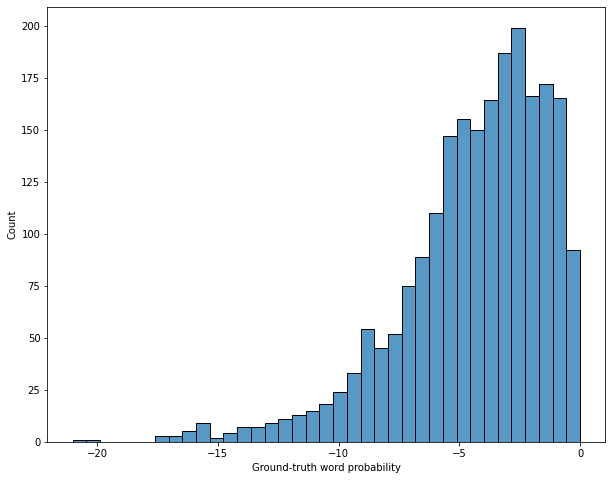

In [8]:
gt_word_probs = stim.p_word[:, 0].numpy()

plt.subplots(figsize=(10, 8))
sns.histplot(gt_word_probs)
plt.xlabel("Ground-truth word probability")

In [9]:
candidate_lengths = (stim.candidate_phonemes != stim.pad_phoneme_id).sum(dim=2)
gt_lengths, candidate_lengths = candidate_lengths[:, 0], candidate_lengths[:, 1:]
candidate_mean_lengths = candidate_lengths.float().mean(dim=1)

<AxesSubplot:title={'center':'Candidate lengths (in phonemes)'}, ylabel='Count'>

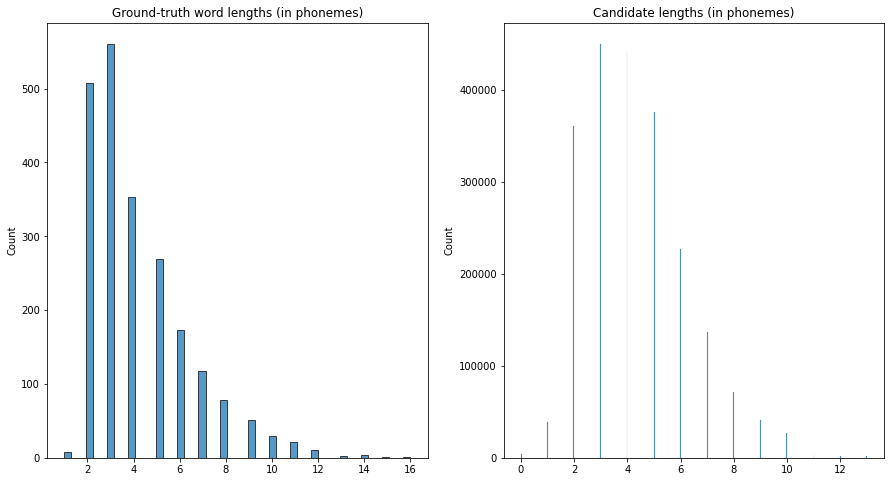

In [10]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.set_title("Ground-truth word lengths (in phonemes)")
ax2.set_title("Candidate lengths (in phonemes)")

sns.histplot(gt_lengths.numpy(), ax=ax1)
sns.histplot(candidate_lengths.flatten().numpy(), ax=ax2)

In [12]:
stim.candidate_phonemes[:, 1:].shape

torch.Size([2187, 999, 16])

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Fraction of candidates which are incremental cohort competitors, by phoneme position'}, xlabel='phoneme', ylabel='is_competitor'>

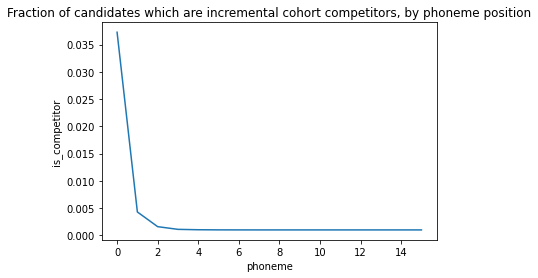

In [15]:
# For each candidate, is it a cohort competitor with ground truth?
# Compute this in batches because it's expensive
max_num_phonemes = stim.candidate_phonemes.shape[2]
is_cohort_competitor = []
batch_size = 256
for i in trange(0, stim.candidate_phonemes.shape[0] + batch_size, batch_size):
    batch = stim.candidate_phonemes[i:i+batch_size]
    if len(batch) == 0:
        break
        
    is_cohort_competitor.append(
        (batch[:, 1:] == batch[:, :1]).cumsum(dim=2) == torch.arange(1, max_num_phonemes + 1))
is_cohort_competitor = torch.concat(is_cohort_competitor, dim=0)

plt.title("Fraction of candidates which are incremental cohort competitors, by phoneme position")
sns.lineplot(data=pd.DataFrame(is_cohort_competitor.reshape(-1, max_num_phonemes).numpy()).melt(var_name="phoneme", value_name="is_competitor"),
             x="phoneme", y="is_competitor", ci=None)

In [16]:
print("Percentage of words which have a candidate which is a cohort competitor for at least one phoneme:",
      is_cohort_competitor.any(dim=2).any(dim=1).float().mean().item() * 100)

Percentage of words which have a candidate which is a cohort competitor for at least one phoneme: 78.37219834327698


In [17]:
print("Percentage of words which have a candidate which is a cohort competitor at phoneme X:\n",
      pd.DataFrame(is_cohort_competitor.any(dim=1).float().mean(dim=0).numpy() * 100))

Percentage of words which have a candidate which is a cohort competitor at phoneme X:
             0
0   78.372200
1   73.845451
2   58.024693
3   49.931412
4   46.822132
5   45.770462
6   45.541840
7   45.313217
8   45.313217
9   45.313217
10  45.313217
11  45.313217
12  45.313217
13  45.313217
14  45.313217
15  45.313217


Median candidate/ground-truth probability ratio for candidates which share ground truth's cohort: 0.005925567355006933


<AxesSubplot:>

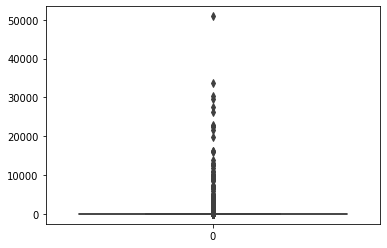

In [47]:
candidate_competitors = is_cohort_competitor.any(dim=2)
gt_probability_ratios = stim.p_word[:, 1:].exp() / stim.p_word[:, :1].exp()

print("Median candidate/ground-truth probability ratio for candidates which share ground truth's cohort:", 
      gt_probability_ratios[candidate_competitors].median().item())
sns.boxplot(data=gt_probability_ratios[candidate_competitors].numpy())